# Etsy Pricing Model

In this notebook, candle data scraped from Etsy is analyzed and then used to build a model for predicting the price of a candle based on various features of the listing and the seller's shop.

Use this model to determine if selling candles on Etsy could be profitable for you, or to set an initial price for a new candle you are selling on Etsy.

**Name** &nbsp; Rebecca Neel

**Date** &nbsp; 11 July, 2023 - 23 July, 2023

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

from sklearn.inspection import permutation_importance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Set a seed for random state.

In [3]:
seed = 92308

## Load and Clean Data

The following data was scraped from Etsy between July 7 and July 11, 2023. (See [this notebook](web-scraping.ipynb) for more details.)

In [4]:
df = pd.read_csv('model_data/data.csv', index_col=0)
df.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,later_days_to_arrival,current_date,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
index,,,,,,,,,,,,,,,,,,,,,
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.4,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...,...,NaN,2023-07-11,HellooAnni,Lovingly Made Clothes & Accessories <3<3,"Emsdetten, Germany",7869.0,872.0,5.0,1375.0,2020.0
144399,"Endless Summer, Soy Candle, Jar Candles, Wood ...",https://www.etsy.com/listing/1144400794/endles...,Brand,ChineshasCloset,16.0,USD,16,4.9691,2420.0,Berry sorbet with light hints of summer flower...,...,17 days 00:00:00,2023-07-11,ChineshasCloset,AWAKEN YOUR SENSES WITH AROMATIC SCENTED CANDL...,"Nashville, Tennessee",8276.0,1172.0,5.0,2420.0,2017.0
147618,Mystery Item from our wonky or Overstock Shelf...,https://www.etsy.com/listing/1075221942/myster...,Brand,TeresaLynnsSimpleLux,12.0,USD,19,4.9475,25699.0,We literally don&#39;t even know what you are ...,...,7 days 00:00:00,2023-07-11,TeresaLynnsSimpleLux,Pure Soy Wax Wooden Wick Candles and Skin Care,"Monrovia, Indiana",87673.0,10218.0,5.0,25723.0,2013.0
16123,Light Teal Turquoise Rustic Unscented Pillar C...,https://www.etsy.com/listing/198199650/light-t...,Brand,StillWaterCandles,16.0,USD,44,4.9282,3750.0,This large light teal unscented rustic pillar ...,...,9 days 00:00:00,2023-07-11,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
7595,Fall Candle / Pure Soy / Autumn Candle / Fall ...,https://www.etsy.com/listing/251445692/fall-ca...,Brand,TheDancingWick,15.0,USD,12,4.9323,29144.0,These candles are my version of the white pump...,...,10 days 00:00:00,2023-07-11,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0


Check null values.

In [5]:
df.isna().sum()

product_name                     0
product_url                      0
brand_type                       0
brand_name                       0
price                            0
currency                         0
position                         0
avg_rating                     274
review_count                   274
product_description              0
seller_response_time          1359
return_and_exchange_policy     159
item_listing_date              145
item_favorites                 305
early_est_arrival              469
later_est_arrival              469
early_days_to_arrival          469
later_days_to_arrival          469
current_date                     0
name                             0
shop_description                 0
location                         1
num_sales                        0
num_admirers                     0
avg_item_review_rounded        272
num_item_reviews               272
on_etsy_since                    0
dtype: int64

### Summary of Cleaning Steps to be Applied

Etsy does not publicize the number of reviews that a shop (brand) has received if the items sold by that shop have not received any reviews in the last year. These shops can probably safely have their review count imputed with the mean. However, for brands which have only been on Etsy since this year, it is safe to say that a null review count reflects a true review count of zero, so we will replace these null values with 0 before imputing the rest with the mean. (The average item review, rounded, and the number of item reviews can be treated similarly.)

It also makes sense to impute the estimated number of days to delivery (minimum and maximum) with the mean. The item listing date can be converted to a "number of days since originally listed" feature and imputed with the mean, as well.

For the two categorical variables (seller response time and the listed return & exchange policy,) it makes sense to treat null values as their own category (having no policy listed might influence buyer trust.)

Finally, the number of favorites that an item has received is not listed on the item's product page if it has not received any favorites, so null values for this feature can be replaced by zero.

Location will not be included in the baseline model (and probably not in the MVP model), but it could be treated as a categorical variable later if we take the time to map more specific locations to broader regions (e.g. northeast United States, eastern Europe, etc.)

Ultimately, the following features will not be included in the MVP model:
- product name *
- product url
- brand type (all the same)
- brand name *
- price (this is the target)
- currency (all the same)
- position
- product description *
- item listing date (use days since listed instead)
- early estimated arrival
- later estimated arrival
- current date
- name (this is the name of the brand, from the brand data dataframe)
- shop description *
- location **

\* These features are NLP features that could be included later.

\** Location could be included later after mapping to broader categories (see above.)

For brands with null review count and on_etsy_since = current year, set review count to 0. We will assume that these sellers have not received any reviews yet.

In [6]:
df.loc[(df.review_count.isna())&(df.on_etsy_since==2023), 'review_count'] = 0

Repeat the above step for avg_item_review and num_item_reviews.

In [7]:
df.loc[(df.num_item_reviews.isna())&(df.on_etsy_since==2023), 'num_item_reviews'] = 0

Other sellers with a null review count likely have not received any reviews in the past year, or their shop has gone inactive since we scraped the initial product data. We will impute these missing values with the mean.

**To be imputed (with the mean):**

avg_rating, avg_item_review_rounded

review_count, num_item_reviews

Return and exchange policy can be categorized into: "not accepted", "free", "cost", "date-restricted", and "not listed".

Replace null values with the string "Not listed."

In [8]:
df.loc[df.return_and_exchange_policy.isna(), 'return_and_exchange_policy'] = "Not listed"

Map return and exchange policies to return and exchange policy categories.

In [9]:
# all costs start with $; date restricted start with "J" or "A" for Jul or Aug
df['return_and_exchange_policy_category'] = df.return_and_exchange_policy.map(lambda x: x[0])

df.loc[df.return_and_exchange_policy_category == 'J', 'return_and_exchange_policy_category'] = 'date_restricted'

df.loc[df.return_and_exchange_policy_category == 'A', 'return_and_exchange_policy_category'] = 'date_restricted'

df.loc[df.return_and_exchange_policy_category == '$', 'return_and_exchange_policy_category'] = 'cost'

df.loc[df.return_and_exchange_policy == 'Not accepted', 'return_and_exchange_policy_category'] = 'not_accepted'

df.loc[df.return_and_exchange_policy == 'Free', 'return_and_exchange_policy_category'] = 'free'

df.loc[df.return_and_exchange_policy == 'Not listed', 'return_and_exchange_policy_category'] = 'not_listed'

In [10]:
df.return_and_exchange_policy_category.value_counts()

not_accepted       2592
date_restricted    1326
cost               1316
free                647
not_listed          159
Name: return_and_exchange_policy_category, dtype: int64

Get days since listing was first posted.

In [11]:
df['days_since_listed'] = pd.to_datetime(df.current_date) - pd.to_datetime(df.item_listing_date)

We will impute null values in the above column with the mean.

Replace null values for "item_favorites" with 0. (This information is not displayed if an item has not been favorited by anyone, so it is null after scraping.)

In [12]:
df.loc[df.item_favorites.isna(), 'item_favorites'] = 0

Impute early and later days to arrival with the mean.

Re-word categories for seller response time.

In [13]:
df.seller_response_time.value_counts()

This seller usually responds within a few hours.    3138
This seller usually responds within 24 hours.       1543
Name: seller_response_time, dtype: int64

In [14]:
df.seller_response_time = \
df.seller_response_time.replace({'This seller usually responds within a few hours.': 'within_a_few_hours',
                                 'This seller usually responds within 24 hours.': 'within_24_hours',
                                 None: 'none_given'})

In [15]:
df.seller_response_time.value_counts()

within_a_few_hours    3138
within_24_hours       1543
none_given            1359
Name: seller_response_time, dtype: int64

Convert datetime objects to float, to avoid issues imputing the mean.

For early days to arrival and later days to arrival, give the number of days as an integer for all non-null values.

(Code note for cell below: the first four lines locate only non-null values and replace them with an integer version of the number of days -- which is currently given as a datetime difference which Pandas interprets as a string. The last two lines can then be used to set the datatype of each column to float.)

In [16]:
df.loc[~df.early_days_to_arrival.isna(), 'early_days_to_arrival'] = \
df.early_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

df.loc[~df.later_days_to_arrival.isna(), 'later_days_to_arrival'] = \
df.later_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

df.early_days_to_arrival = df.early_days_to_arrival.astype(float)
df.later_days_to_arrival = df.later_days_to_arrival.astype(float)

Give the number of days since an item was listed (on Etsy) as a float.

(Code note for cell below: once again, the first two lines replace non-null values with the integer version of their current value which is given as a "timedelta64\[ns\]" datatype; the third line replaces the string "NaT" which results from a null datetime value with a true null value; the last line changes the datatype of this feature to a float.)

In [17]:
df.loc[~(df.days_since_listed.isna()), 'days_since_listed'] = \
df.days_since_listed.dropna().map(lambda x: int(str(x).split()[0]))

df.loc[df.days_since_listed.map(lambda x: str(x)) == 'NaT', 'days_since_listed'] = None

df.days_since_listed = df.days_since_listed.astype(float)

## Exploratory Data Analysis

In the following sections, I explore the distribution of features and target, as well as potential correlation between features and target.

### Features

#### Numerical

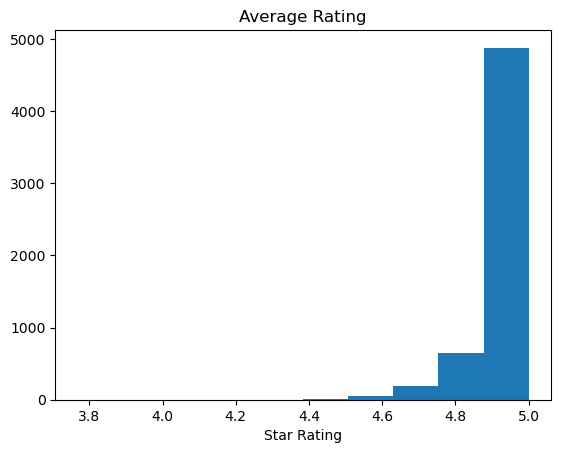

In [53]:
fig, ax = plt.subplots()

df.avg_rating.plot(kind='hist', ax=ax)
ax.set(title='Average Rating', ylabel='', xlabel='Star Rating');

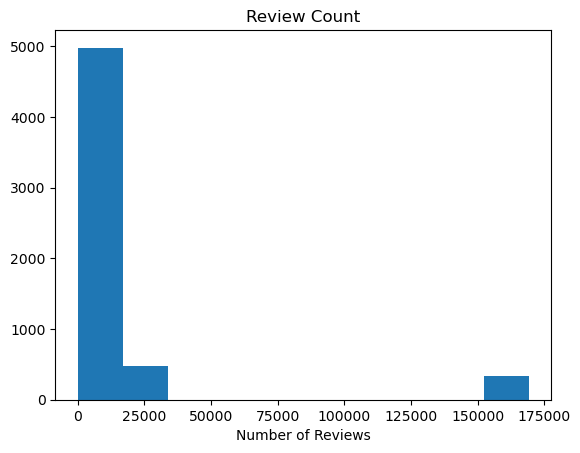

In [55]:
fig, ax = plt.subplots()

df.review_count.plot(kind='hist', ax=ax)
ax.set(title='Review Count', ylabel='', xlabel='Number of Reviews');

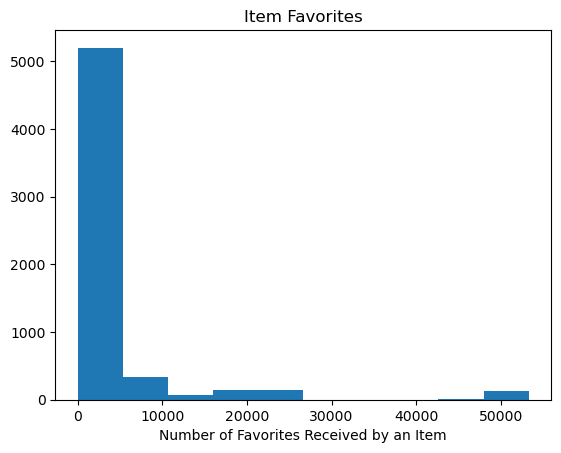

In [56]:
fig, ax = plt.subplots()

df.item_favorites.plot(kind='hist', ax=ax)
ax.set(title='Item Favorites', ylabel='', xlabel='Number of Favorites Received by an Item');

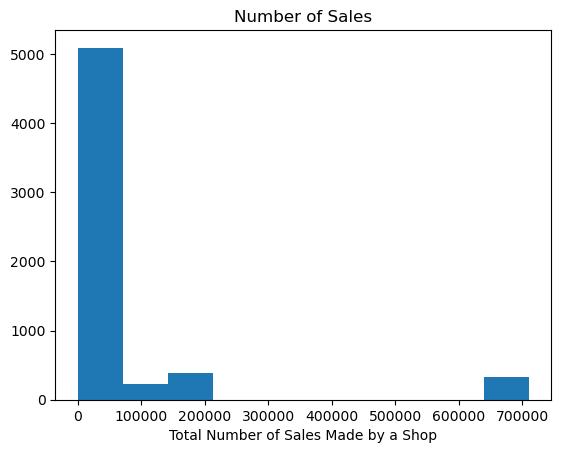

In [58]:
fig, ax = plt.subplots()

df.num_sales.plot(kind='hist', ax=ax)
ax.set(title='Number of Sales', ylabel='', xlabel='Total Number of Sales Made by a Shop');

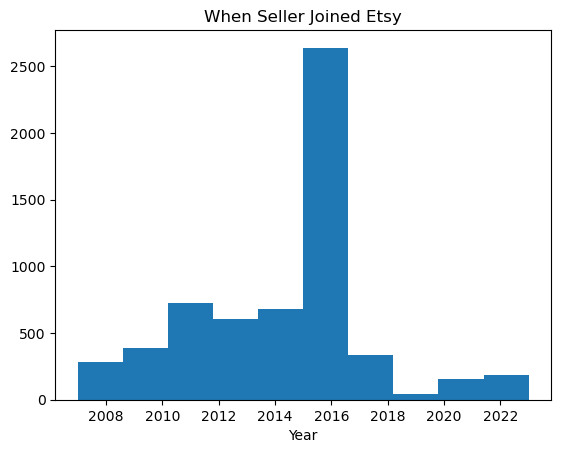

In [60]:
fig, ax = plt.subplots()

df.on_etsy_since.plot(kind='hist', ax=ax)
ax.set(title='When Seller Joined Etsy', ylabel='', xlabel='Year');

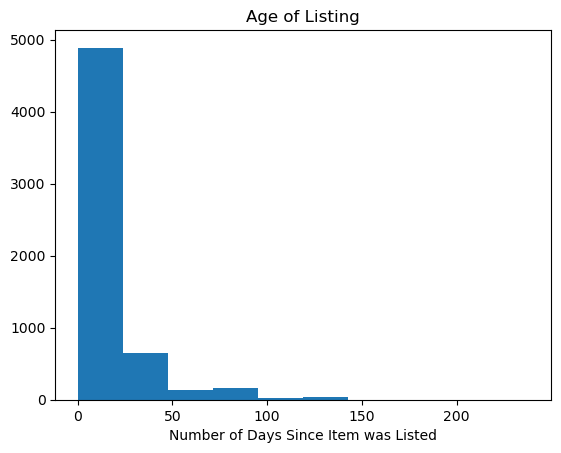

In [63]:
fig, ax = plt.subplots()

df.days_since_listed.plot(kind='hist', ax=ax)
ax.set(title='Age of Listing', ylabel='', xlabel='Number of Days Since Item was Listed');

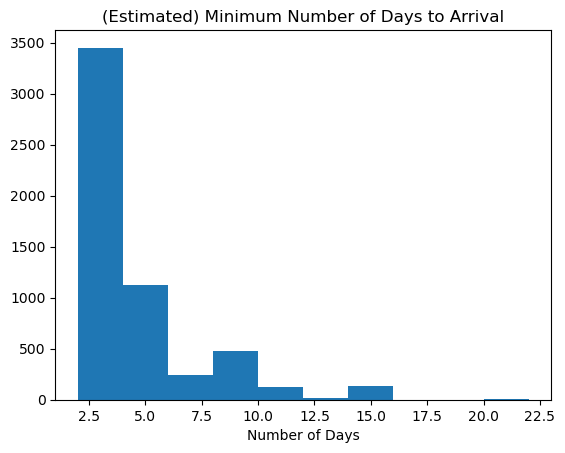

In [66]:
fig, ax = plt.subplots()

df.early_days_to_arrival.plot(kind='hist', ax=ax)
ax.set(title='(Estimated) Minimum Number of Days to Arrival', ylabel='', xlabel='Number of Days');

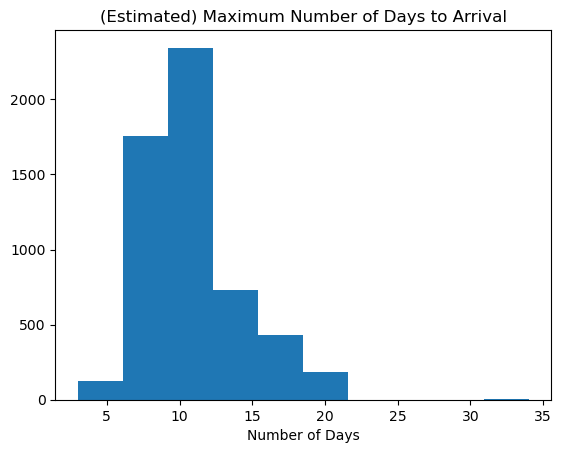

In [67]:
fig, ax = plt.subplots()

df.later_days_to_arrival.plot(kind='hist', ax=ax)
ax.set(title='(Estimated) Maximum Number of Days to Arrival', ylabel='', xlabel='Number of Days');

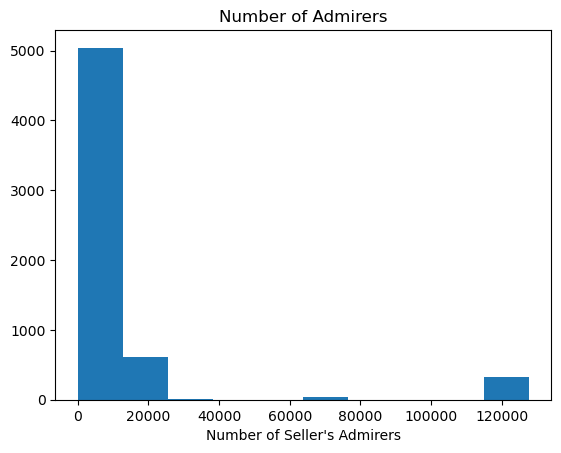

In [69]:
fig, ax = plt.subplots()

df.num_admirers.plot(kind='hist', ax=ax)
ax.set(title='Number of Admirers', ylabel='', xlabel="Number of Seller's Admirers");

#### Categorical

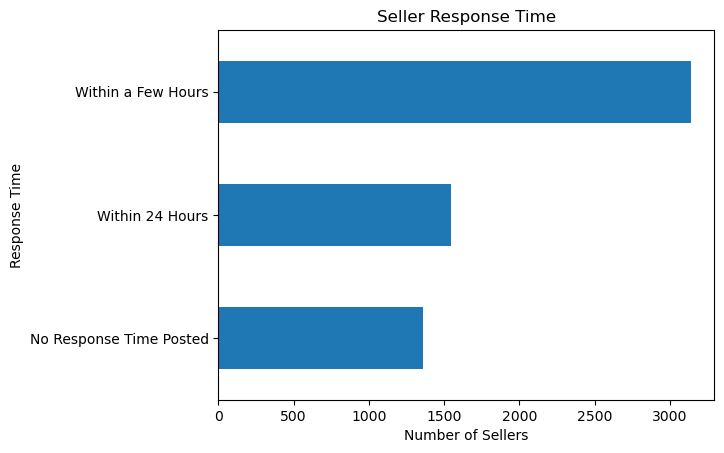

In [78]:
fig, ax = plt.subplots()

df.seller_response_time.value_counts().plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set(title='Seller Response Time', ylabel='Response Time', xlabel='Number of Sellers')
ax.set_yticklabels(['Within a Few Hours', 'Within 24 Hours', 'No Response Time Posted']);

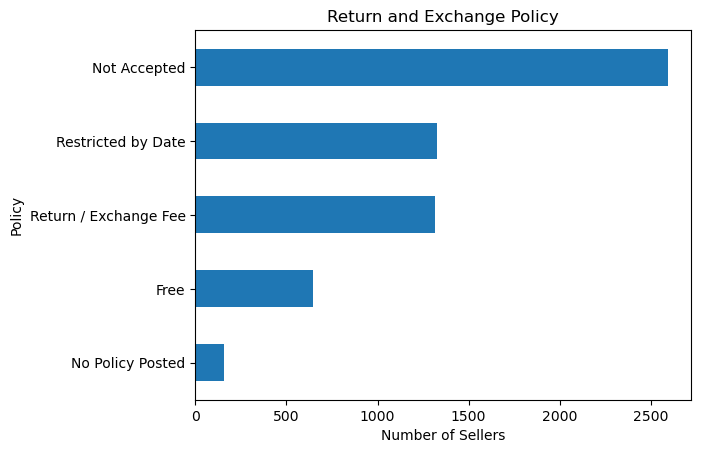

In [79]:
fig, ax = plt.subplots()

df.return_and_exchange_policy_category.value_counts().plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set(title='Return and Exchange Policy', ylabel='Policy', xlabel='Number of Sellers')
ax.set_yticklabels(['Not Accepted', 'Restricted by Date', 'Return / Exchange Fee', 'Free', 'No Policy Posted']);

## Correlation

Check for correlations between numerical features, and correlations of numerical features with the target. The heatmap will be easier to read if we remove the diagonal and lower "triangle" of the matrix (to avoid extraneous and repetitive information, respectively) so do so using numpy functions.

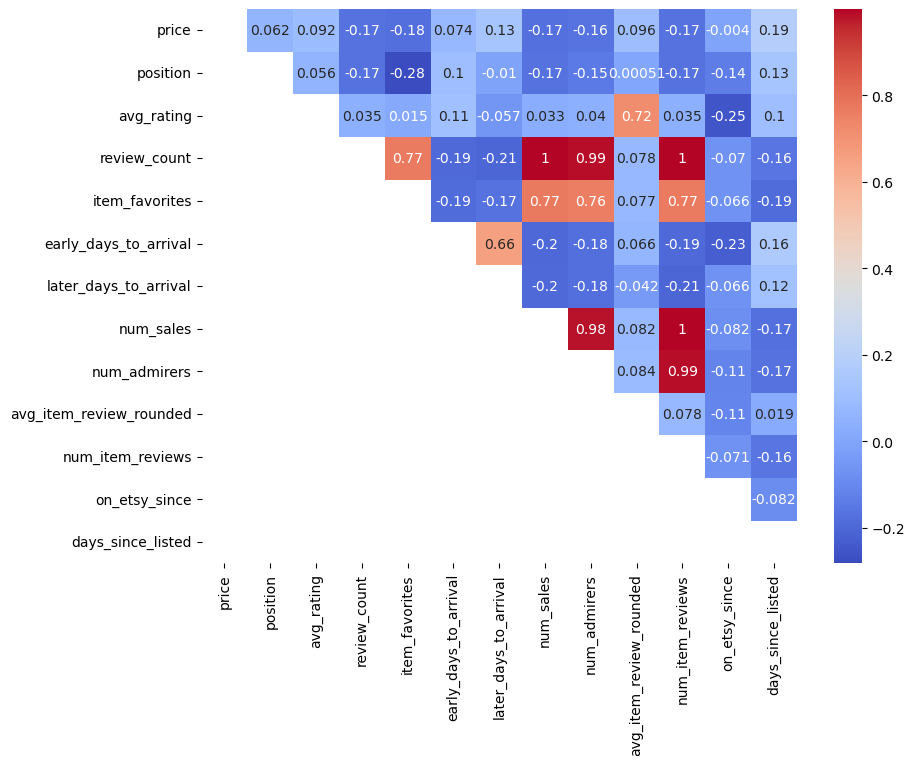

In [28]:
# remove diagonal and repeated values; k=1 to exclude diagonal
upperMatrix = df.corr(numeric_only=True).where(np.triu(np.ones(df.corr(numeric_only=True).shape), k=1).astype(bool))

fig, ax = plt.subplots(figsize=(9.6, 7.2))

# print(fig.get_size_inches()) # check current fig size to preserve dimensions when scaling

sns.heatmap(upperMatrix, annot=True, fmt='.2g', cmap='coolwarm', ax=ax)

fig.savefig('images/correlation_plot.jpg', bbox_inches='tight');

Review count is strongly correlated with number of sales, number of admirers and number of item reviews. The number of favorites that an item has is also strongly correlated to the above four features, although substantially less so.

Unfortunately, very few numerical features in the dataset have a strong correlation to price. :(

Most positively correlated feature to price: days_since_listed

Most negatively correlated features to price: num_sales and num_admirers

*(Perhaps lower-priced candles tend to sell more frequently and produce more loyalty to the seller.)*

### "Correlation" of Categorical Features with Target

How does response time affect price?

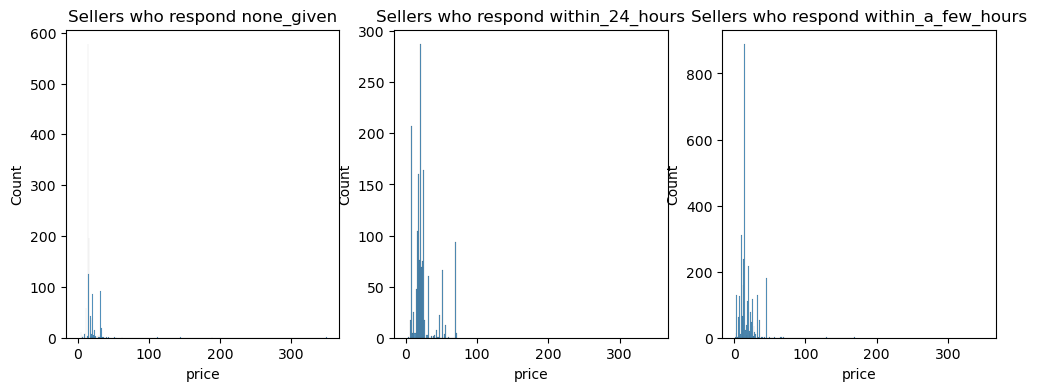

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharex=True)
i=0

for response_time in np.unique(df.seller_response_time):
    sns.histplot(df.loc[df.seller_response_time==response_time, 'price'], ax=ax[i])
    ax[i].set_title(f'Sellers who respond {response_time}');
    i+=1

How does a listed return and exchange policy affect price?

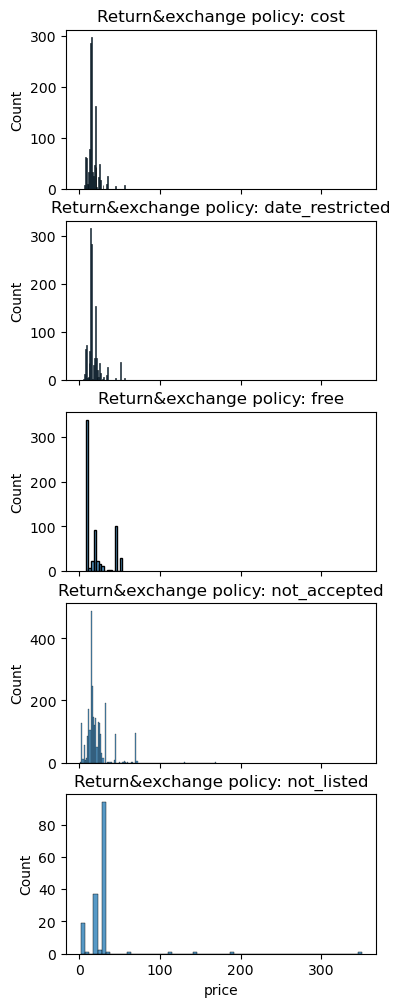

In [86]:
fig, ax = plt.subplots(nrows=5, figsize=(4, 12), sharex=True)
i=0

for policy in np.unique(df.return_and_exchange_policy_category):
    sns.histplot(df.loc[df.return_and_exchange_policy_category==policy, 'price'], ax=ax[i])
    ax[i].set_title(f'Return&exchange policy: {policy}');
    i+=1

## Distribution of Target

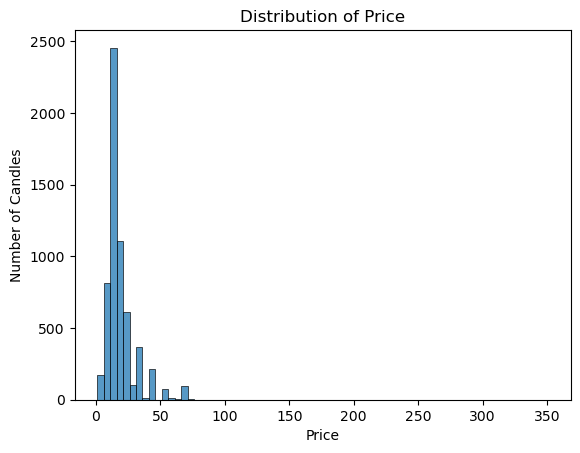

In [19]:
fig, ax = plt.subplots()

sns.histplot(df['price'], binwidth=5, ax=ax)

ax.set(title='Distribution of Price', xlabel='Price', ylabel='Number of Candles');

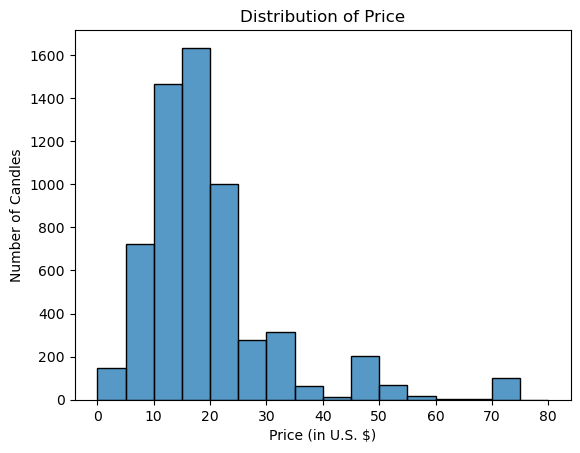

In [27]:
fig, ax = plt.subplots()

sns.histplot(df.loc[df.price < 80, 'price'], binwidth=5, binrange=[0, 80], ax=ax)

ax.set(title='Distribution of Price', xlabel='Price (in U.S. $)', ylabel='Number of Candles')

fig.savefig('images/price_dist.jpg', bbox_inches='tight');

/Users/user/opt/anaconda3/envs/etsy-demand-model/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


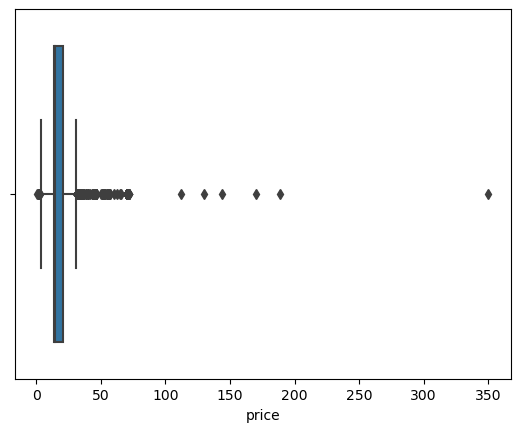

In [32]:
sns.boxplot(df['price'], ax=ax);

In [33]:
df['price'].describe()

count    6040.000000
mean       19.505818
std        12.828481
min         1.020000
25%        13.990000
50%        15.000000
75%        20.990000
max       350.000000
Name: price, dtype: float64

Most candles are priced within a very narrow range. It might be beneficial to remove outliers before modeling.

#### Inspecting Outliers

On brief inspection via random sampling, the higher-priced "candles" tend to be either custom or personalized in some way, or gift sets or sets that contain multiple candles.

## Train Test Split

Drop columns not needed for modeling.

In [30]:
X = df.drop(columns=['product_name', 'product_url', 'brand_type', 'brand_name', 'price', 'currency', 'position',
                     'product_description', 'return_and_exchange_policy', 'item_listing_date', 'early_est_arrival',
                     'later_est_arrival', 'current_date', 'name', 'shop_description', 'location']
                       )
y = df['price'].copy()

X.head()

,avg_rating,review_count,seller_response_time,item_favorites,early_days_to_arrival,later_days_to_arrival,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since,return_and_exchange_policy_category,days_since_listed
index,,,,,,,,,,,,,
29337,4.9766,1363.0,within_a_few_hours,53.0,NaN,NaN,7869.0,872.0,5.0,1375.0,2020.0,not_listed,2.0
144399,4.9691,2420.0,within_a_few_hours,2.0,11.0,17.0,8276.0,1172.0,5.0,2420.0,2017.0,not_accepted,2.0
147618,4.9475,25699.0,within_a_few_hours,1307.0,2.0,7.0,87673.0,10218.0,5.0,25723.0,2013.0,date_restricted,0.0
16123,4.9282,3750.0,none_given,762.0,8.0,9.0,20080.0,3958.0,5.0,3752.0,2011.0,not_accepted,0.0
7595,4.9323,29144.0,within_a_few_hours,17705.0,2.0,10.0,150866.0,21155.0,5.0,29173.0,2011.0,date_restricted,0.0


Train-val-test split.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

print(f'Train size: {X_train.shape[0]}')
print(f'Val size: {X_val.shape[0]}')
print(f'Test size: {X_test.shape[0]}')

Train size: 4010
Val size: 1003
Test size: 1027


## Remove Outliers (from Training Data Only)

Remove outliers from the training data only, based on training data statistics.

In [32]:
price_IQR = y_train.quantile(0.75) - y_train.quantile(0.25)
cutoff = 1.5*price_IQR

min_acceptable_price = y_train.quantile(0.25) - cutoff
max_acceptable_price = y_train.quantile(0.75) + cutoff

print(f'Interquartile range: ${round(price_IQR, 2)}')
print(f'Min acceptable price: ${round(min_acceptable_price, 2)}')
print(f'Max acceptable price: ${round(max_acceptable_price, 2)}')

Interquartile range: $7.73
Min acceptable price: $2.4
Max acceptable price: $33.31


In [33]:
X_train_no_outliers = X_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]
y_train_no_outliers = y_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]

In [34]:
print(X_train.shape)
print(X_train_no_outliers.shape)
print(y_train_no_outliers.shape)

(4010, 13)
(3663, 13)
(3663,)


347 outliers were removed from the training data.

## Preprocess Data for Modeling

Column Transformer:

- One hot encode categorical variables.

- Impute numerical features that have missing values with the mean.

- "Pass through" numerical features that do not have missing values.

Pipeline:

- Column transformer

&nbsp; &nbsp; &nbsp; *Applies steps above to appropriate features.*

- Standard scaler

&nbsp; &nbsp; &nbsp; *Scale all of the data, after one hot encoding and imputing, using a standard scaler default strategy.*

In [35]:
ohe = OneHotEncoder(drop='first')
si = SimpleImputer()

categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']

numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)

ss = StandardScaler()

X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(X_train_no_outliers)),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train_no_outliers.index)
X_val_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_val)),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_val.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

X_train_preprocessed.head()

,num__avg_rating,num__review_count,num__early_days_to_arrival,num__later_days_to_arrival,num__avg_item_review_rounded,num__num_item_reviews,num__days_since_listed,cat__seller_response_time_within_24_hours,cat__seller_response_time_within_a_few_hours,cat__return_and_exchange_policy_category_date_restricted,cat__return_and_exchange_policy_category_free,cat__return_and_exchange_policy_category_not_accepted,cat__return_and_exchange_policy_category_not_listed,remainder__item_favorites,remainder__num_sales,remainder__num_admirers,remainder__on_etsy_since
index,,,,,,,,,,,,,,,,,
106418,0.095598,3.963731,-0.597592,-0.561669,0.212221,3.963522,-0.542417,-0.556012,0.958019,-0.529877,3.194031,-0.866577,-0.173465,5.541449,3.927893,3.904677,-0.112142
133961,-1.039867,-0.397761,-0.597592,-0.561669,0.212221,-0.397525,-0.492463,1.798522,-1.043820,-0.529877,-0.313084,1.153965,-0.173465,-0.307002,-0.396512,-0.409710,0.844632
609,-1.282285,-0.400251,-0.597592,-0.228560,0.212221,-0.399961,-0.042881,1.798522,-1.043820,1.887232,-0.313084,-0.866577,-0.173465,-0.462886,-0.412880,-0.433033,-0.112142
156440,-0.201156,-0.318877,-0.597592,-1.227886,0.212221,-0.318693,-0.492463,-0.556012,-1.043820,-0.529877,-0.313084,-0.866577,-0.173465,0.253048,-0.317897,-0.304177,0.525708
18790,-0.155180,-0.317684,-0.206470,0.104549,0.212221,-0.317424,-0.342602,-0.556012,0.958019,-0.529877,-0.313084,1.153965,-0.173465,-0.000319,-0.318628,-0.391825,0.844632


## Modeling

**Evaluation metric:** &nbsp; RMSE

**Simple baseline:** &nbsp; Predict the mean (of the training data)

In [36]:
def rmse(y_true, y_pred):
    '''Returns the root mean squared error of a model which makes predictions y_pred for the true values y_true.'''
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
# get predictions for training set
y_pred_train = y_train_no_outliers.mean() * np.ones(y_train.shape)

# get predictions for validation set
y_pred_val = y_train_no_outliers.mean() * np.ones(y_val.shape)

# print results
print(f'Training RMSE: ${round(rmse(y_train, y_pred_train), 2)}')
print(f'Validation RMSE: ${round(rmse(y_val, y_pred_val), 2)}')

Training RMSE: $12.62
Validation RMSE: $11.34


We are looking for a model with a root mean squared error less than \\$11 to \\$12.

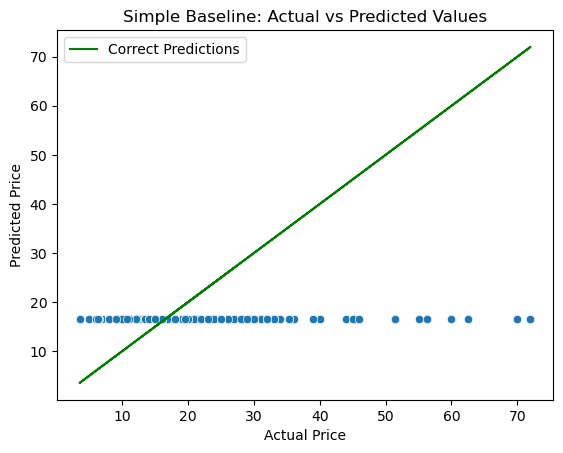

In [43]:
# visualize predictions for validation data
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_pred_val, ax=ax)
plt.plot(y_val, y_val, label='Correct Predictions', c='g')

ax.set(title='Simple Baseline: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price')
ax.legend()

fig.savefig('images/simple_baseline.jpg', bbox_inches='tight');

It makes sense that the simple baseline model would tend to underestimate the price of more expensive candles in the validation data since we obtained the mean from the training data *after* removing outliers (most of which were more expensive personalized candles or sets of candles.) These "outliers" are still present in the validation data.

## Linear Model Approach

### Baseline Multiple Linear Regression

Instantiate and train a baseline multiple linear regression model.

In [130]:
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, lr.predict(X_train_preprocessed)))}')
print(f'RMSE on Validation Data: {np.sqrt(mean_squared_error(y_val, lr.predict(X_val_preprocessed)))}')

RMSE on Training Data: 5.693799749542232
RMSE on Test Data: 10.946042494251751


A baseline multiple linear regression model is

i.) overfit, and

ii.) only slightly better than the simple baseline (in terms of validation RMSE.)

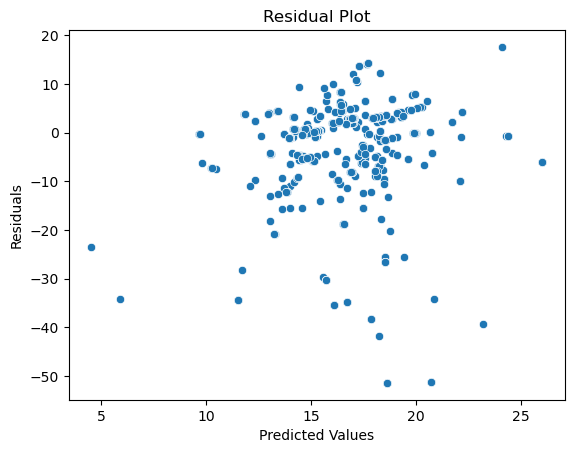

In [131]:
# fitted values versus residuals
y_val_pred = lr.predict(X_val_preprocessed)
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

There is no clear pattern in the residuals, so it is possible that a linear model is appropriate for this regression problem.

However, the RMSE is not as low as I would like it to be, so I am going to explore the effect of adding polynomial features, anyway.

### Degree 2 Polynomial Terms

In [137]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_degree_2 = poly.fit_transform(X_train_preprocessed)

Fit a linear model to the training data with degree 2 polynomial features included (including interaction terms.)

In [138]:
lr.fit(poly_features_degree_2, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, lr.predict(poly_features_degree_2)))}')
print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_val, lr.predict(poly.transform(X_val_preprocessed))))}')

RMSE on Training Data: 3.6268646799874227
RMSE on Test Data: 29.55938081595699


This model is significantly worse (in terms of being much more overfit to the training data and having a higher RMSE on the validation data.) I want to briefly check whether L1 regularization improves the model; it's possible that the target has a nonlinear dependence on some features, but not all, and applying L1 regularization is a quick way to prune unnecessary nonlinear (and linear) features.

###  L1 Regularization, Degree 2 Polynomial Terms

In [141]:
l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(poly_features_degree_2, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 5.8468736300774795


Also check the training score.

In [157]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.8097558865106045

L1 regularization improves the model considerably. The coefficients of most features have been set to zero - which features, polynomial or otherwise, survived?

In [153]:
poly.get_feature_names_out()[np.nonzero(grid_search.best_estimator_.coef_)]

array(['num__avg_rating cat__return_and_exchange_policy_category_not_listed',
       'num__review_count num__num_item_reviews',
       'num__early_days_to_arrival^2', 'num__avg_item_review_rounded^2',
       'num__num_item_reviews^2', 'num__days_since_listed^2',
       'cat__seller_response_time_within_24_hours^2',
       'cat__seller_response_time_within_24_hours cat__return_and_exchange_policy_category_not_accepted',
       'cat__return_and_exchange_policy_category_not_listed^2',
       'remainder__item_favorites remainder__num_admirers'], dtype=object)

Check the assumptions of linear regression.

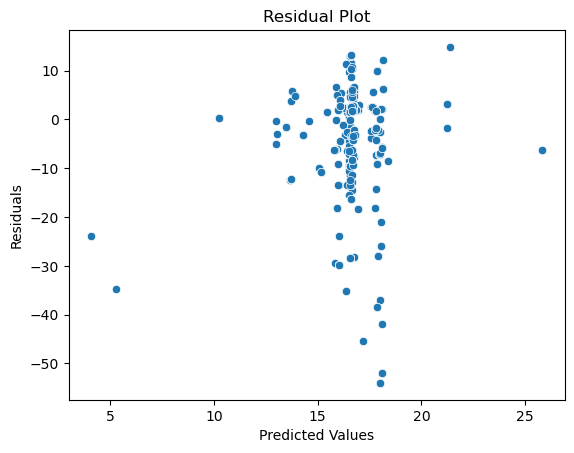

In [155]:
# clone best model and fit to training data (degree 2 polynomial version)
degree_2_model = clone(grid_search.best_estimator_)
degree_2_model.fit(poly_features_degree_2, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = degree_2_model.predict(poly.transform(X_val_preprocessed))
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

There seems to be more of a pattern in the residuals for the degree 2 model, so it is possible that it is not a good fit overall.

Check a degree 3 model with L1 regularization.

### L1 Regularization, Degree 3 Polynomial Terms

In [44]:
poly3 = PolynomialFeatures(degree=3, include_bias=False)
poly_features_degree_3 = poly3.fit_transform(X_train_preprocessed)

l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(poly_features_degree_3, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 5.649214615928614


The best model with degree 3 polynomial terms and L1 regularization performs just slightly better than the degree 2 version. There is no need to overcomplicate the model unnecessarily, so this improvement may not be worth pursuing, but let's check the model stats regardless.

Training score:

In [165]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.282957621901111

Included features:

In [166]:
poly3.get_feature_names_out()[np.nonzero(grid_search.best_estimator_.coef_)]

array(['num__avg_rating^3',
       'num__avg_rating^2 num__avg_item_review_rounded',
       'num__avg_rating num__days_since_listed^2',
       'num__avg_rating cat__return_and_exchange_policy_category_not_listed^2',
       'num__review_count^2 remainder__item_favorites',
       'num__early_days_to_arrival^3',
       'num__early_days_to_arrival^2 remainder__on_etsy_since',
       'num__early_days_to_arrival num__days_since_listed^2',
       'num__later_days_to_arrival^3',
       'num__later_days_to_arrival^2 num__days_since_listed',
       'num__later_days_to_arrival num__days_since_listed^2',
       'num__later_days_to_arrival cat__seller_response_time_within_24_hours cat__return_and_exchange_policy_category_free',
       'num__later_days_to_arrival remainder__on_etsy_since^2',
       'num__avg_item_review_rounded^3',
       'num__avg_item_review_rounded^2 num__days_since_listed',
       'num__avg_item_review_rounded^2 cat__seller_response_time_within_a_few_hours',
       'num__avg_ite

Assumptions of linear regression:

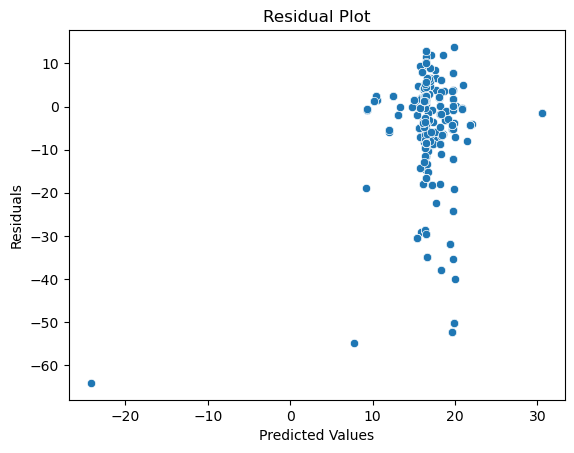

In [46]:
# clone best model and fit to training data (degree 2 polynomial version)
degree_3_model = clone(grid_search.best_estimator_)
degree_3_model.fit(poly_features_degree_3, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = degree_3_model.predict(poly3.transform(X_val_preprocessed))
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

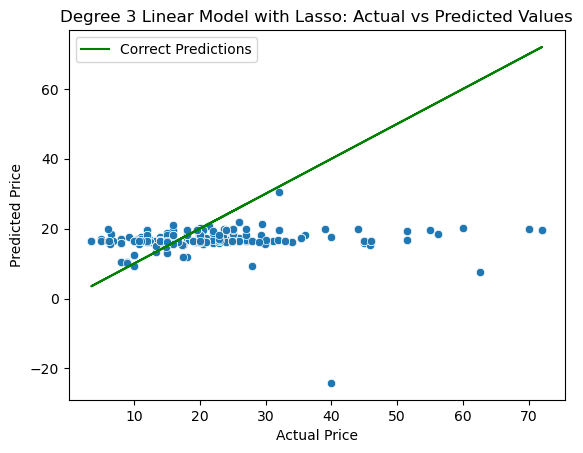

In [51]:
# visualize predictions for validation data
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_val_pred, ax=ax)
plt.plot(y_val, y_val, label='Correct Predictions', c='g')

ax.set(title='Degree 3 Linear Model with Lasso: Actual vs Predicted Values', xlabel='Actual Price',
       ylabel='Predicted Price')
ax.legend()

fig.savefig('images/best_linear_model.jpg', bbox_inches='tight');

### L1 Regularization, Linear Model

Speaking of overcomplicating the model, I have not tested the effect of using L1 regularization without any polynomial terms - let me try this now to see if we can get a better RMSE with regularization without polynomial terms.

In [160]:
l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 6.270683237434787


The best validation RMSE for a linear model with no interaction terms and L1 regularization is higher than that of a model with degree 2 or degree 3 polynomial terms.

### L2 Regularization, Linear Model

Check the effects of L2 regularization on a strictly linear model.

In [163]:
ridge = Ridge()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(ridge, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Training score:

In [168]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.282957621901111

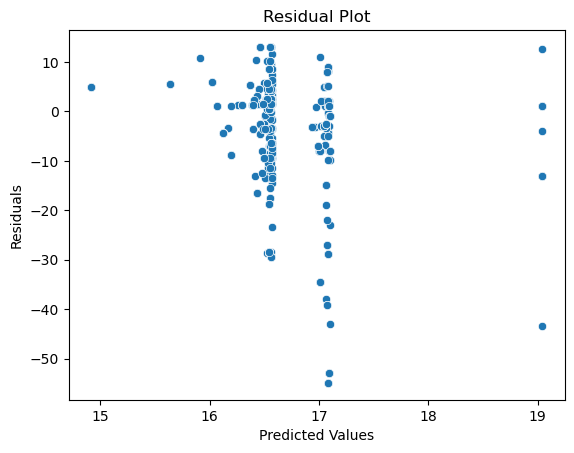

In [169]:
# clone best model and fit to training data (degree 2 polynomial version)
ridge_model = clone(grid_search.best_estimator_)
ridge_model.fit(X_train_preprocessed, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = ridge_model.predict(X_val_preprocessed)
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

Our best linear model so far, by a narrow margin, is still the degree 3 polynomial with L1 regularization with a validation RMSE of \\$5.65.

## Random Forest Regression

### Random Forest Baseline

Instantiate and train a baseline random forest regression model.

In [47]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, rf.predict(X_train_preprocessed)))}')

print(f'RMSE on Validation Data: {np.sqrt(mean_squared_error(y_val, rf.predict(X_val_preprocessed)))}')

RMSE on Training Data: 0.6034597343860354
RMSE on Validation Data: 9.963038172826145


Check the maximum depth of trees in this forest.

In [48]:
print(np.mean([tree.get_depth() for tree in rf.estimators_]))
print(np.std([tree.get_depth() for tree in rf.estimators_]))

18.71
1.6449620056402519


Trees in the baseline random forest have a maximum depth generally ranging from 17 to 20.

### Tuning Random Forest

Tune random forest regression.

In [46]:
param_grid = [
    {'max_depth': [1, 5, 10, 15, 20, 25],
     'max_features': [0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(rf, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)
grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Best validation RMSE: $1.65
Training RMSE for best model: $0.68


Visualize predictions for validation data:

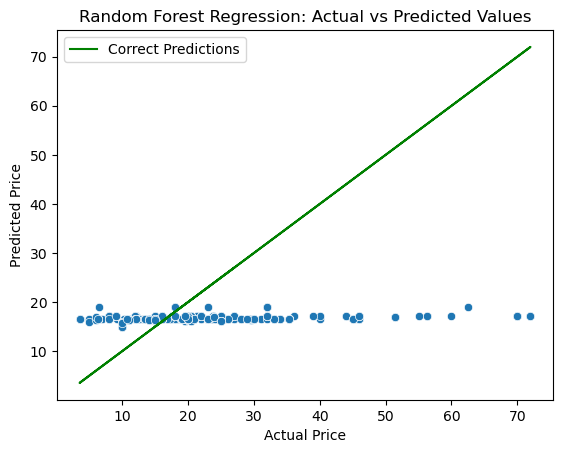

In [52]:
# visualize predictions for validation data
# clone & fit best model
best_rf_model = clone(grid_search.best_estimator_)
best_rf_model.fit(X_train_preprocessed, y_train_no_outliers)
# get predictions for validation data
y_val_pred = best_rf_model.predict(X_val_preprocessed)

# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_val_pred)
plt.plot(y_val, y_val, label='Correct Predictions', c='g')

ax.set(title='Random Forest Regression: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price')
ax.legend();

The model tends to under-price candles in the validation data that have a price higher than the maximum acceptable price to exclude outliers (unsurprisingly.)

In [192]:
max_acceptable_price

33.30875

Let's zoom in on candles within the "acceptable" price range in the validation set (non-outliers.)

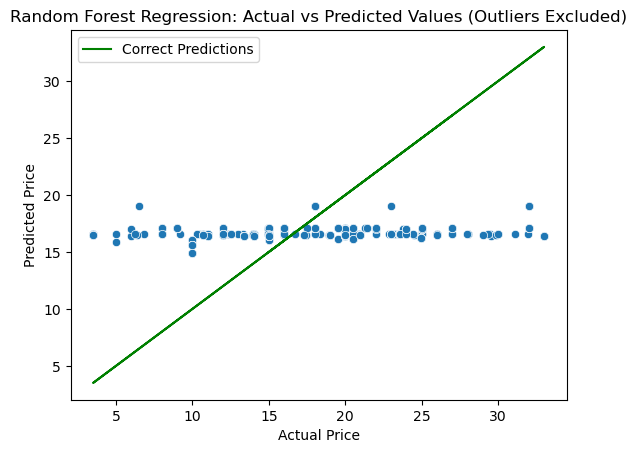

In [57]:
# visualize predictions for validation data
# clone & fit best model
best_rf_model = clone(grid_search.best_estimator_)
best_rf_model.fit(X_train_preprocessed, y_train_no_outliers)
# get predictions for validation data
y_val_pred = best_rf_model.predict(X_val_preprocessed[(y_val < max_acceptable_price)&(y_val > min_acceptable_price)])

# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_val[(y_val < max_acceptable_price)&(y_val > min_acceptable_price)], y=y_val_pred)
plt.plot(y_val[(y_val < max_acceptable_price)&(y_val > min_acceptable_price)],
         y_val[(y_val < max_acceptable_price)&(y_val > min_acceptable_price)], label='Correct Predictions', c='g')

ax.set(title='Random Forest Regression: Actual vs Predicted Values (Outliers Excluded)',
       xlabel='Actual Price',
       ylabel='Predicted Price')
ax.legend()

fig.savefig('images/best_rf_model.jpg', bbox_inches='tight');

## XG Boost Model

### XG Boost Baseline Model

In [194]:
xgb = XGBRegressor()
xgb.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: ${round(np.sqrt(mean_squared_error(y_train_no_outliers, xgb.predict(X_train_preprocessed))), 2)}')

print(f'RMSE on Test Data: ${round(np.sqrt(mean_squared_error(y_val, xgb.predict(X_val_preprocessed))), 2)}')

RMSE on Training Data: $0.09
RMSE on Test Data: $10.42


### Tuning XG Boost

Tune XG Boost.

In [196]:
param_grid = [
    {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
     'max_depth': [1, 5, 10, 15, 20, 25],
     'subsample': [0.25, 0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid=[{'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                          'max_depth': [1, 5, 10, 15, 20, 25],
                          'n_estimators': [100, 200], 'random_state': [92308],
                          'subsample': [0.25, 0.5, 0.75, 1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [197]:
print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Best validation RMSE: $1.73
Training RMSE for best model: $0.43


Visualize predictions for validation data:

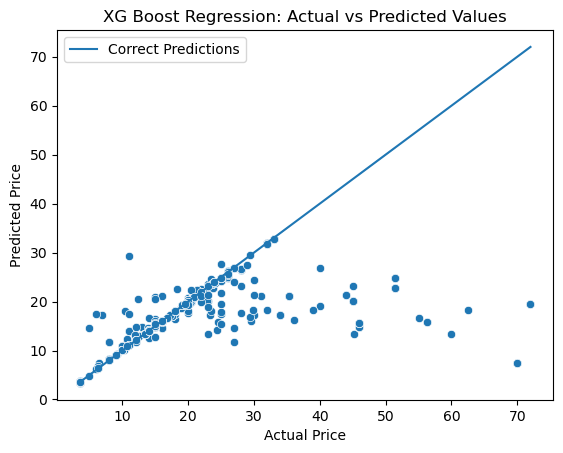

In [199]:
# visualize predictions for validation data
# clone & fit best model
best_xgb_model = clone(grid_search.best_estimator_)
best_xgb_model.fit(X_train_preprocessed, y_train_no_outliers)
# get predictions for validation data
y_val_pred = best_xgb_model.predict(X_val_preprocessed)

# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_val_pred)
sns.lineplot(x=y_val, y=y_val, label='Correct Predictions')

ax.set(title='XG Boost Regression: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price');

## Remove Fewer Outliers

Rather than using the interquartile range - based cutoff, I want to try setting a custom maximum acceptable price of \\$50 to see if the model can learn how to price more expensive candles a little bit better.

In [17]:
price_IQR = y_train.quantile(0.75) - y_train.quantile(0.25)
cutoff = 1.5*price_IQR

min_acceptable_price = y_train.quantile(0.25) - cutoff
max_acceptable_price = 50

print(f'Interquartile range: ${round(price_IQR, 2)}')
print(f'Min acceptable price: ${round(min_acceptable_price, 2)}')
print(f'Max acceptable price: ${round(max_acceptable_price, 2)}')

X_train_no_outliers = X_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]
y_train_no_outliers = y_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]

Interquartile range: $7.73
Min acceptable price: $2.4
Max acceptable price: $50


Repeat preprocessing steps for modeling (one hot encoding, imputing with the mean, and scaling.)

In [18]:
ohe = OneHotEncoder(drop='first')
si = SimpleImputer()

categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']

numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)

ss = StandardScaler()

X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(X_train_no_outliers)),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train_no_outliers.index)
X_val_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_val)),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_val.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

X_train_preprocessed.head()

,num__avg_rating,num__review_count,num__early_days_to_arrival,num__later_days_to_arrival,num__avg_item_review_rounded,num__num_item_reviews,num__days_since_listed,cat__seller_response_time_within_24_hours,cat__seller_response_time_within_a_few_hours,cat__return_and_exchange_policy_category_date_restricted,cat__return_and_exchange_policy_category_free,cat__return_and_exchange_policy_category_not_accepted,cat__return_and_exchange_policy_category_not_listed,remainder__item_favorites,remainder__num_sales,remainder__num_admirers,remainder__on_etsy_since
index,,,,,,,,,,,,,,,,,
106418,0.061788,4.082397,-0.618138,-0.588062,0.205684,4.082176,-0.559991,-0.545731,0.928227,-0.523777,2.942932,-0.859069,-0.169345,5.695774,4.043986,4.020415,-0.073082
133961,-1.087396,-0.385780,-0.618138,-0.588062,0.205684,-0.385565,-0.511959,1.832404,-1.077323,-0.523777,-0.339797,1.164051,-0.169345,-0.291838,-0.383782,-0.397989,0.879115
609,-1.332743,-0.388330,-0.618138,-0.256082,0.205684,-0.388060,-0.079672,1.832404,-1.077323,1.909210,-0.339797,-0.859069,-0.169345,-0.451430,-0.400541,-0.421874,-0.073082
156440,-0.238551,-0.304966,-0.618138,-1.252020,0.205684,-0.304805,-0.511959,-0.545731,-1.077323,-0.523777,-0.339797,-0.859069,-0.169345,0.281539,-0.303289,-0.289911,0.561716
18790,-0.192019,-0.303744,-0.232623,0.075897,0.205684,-0.303504,-0.367863,-0.545731,0.928227,-0.523777,-0.339797,1.164051,-0.169345,0.022143,-0.304037,-0.379672,0.879115


### Linear Model, with Some Outliers Included

#### Baseline

In [20]:
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on training data: ${round(rmse(y_train_no_outliers, lr.predict(X_train_preprocessed)), 2)}')
print(f'RMSE on validation data: ${round(rmse(y_val, lr.predict(X_val_preprocessed)), 2)}')

RMSE on training data: $7.66
RMSE on validation data: $10.6


#### Best "Linear" Model So Far

score to beat: \\$5.65 val RMSE

In [27]:
poly3 = PolynomialFeatures(degree=3, include_bias=False)
poly_features_degree_3 = poly3.fit_transform(X_train_preprocessed)

l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'max_iter': [10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(poly_features_degree_3, y_train_no_outliers)

print(f'Best validation RMSE: ${round(-1*grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

/Users/user/opt/anaconda3/envs/etsy-demand-model/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+01, tolerance: 1.964e+01
  model = cd_fast.enet_coordinate_descent(


Best validation RMSE: $7.31
Training RMSE for best model: $6.85


### Random Forest, with Some Outliers Included

#### Baseline

In [28]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: ${round(rmse(y_train_no_outliers, rf.predict(X_train_preprocessed)), 2)}')
print(f'RMSE on Test Data: ${round(rmse(y_test, rf.predict(X_test_preprocessed)), 2)}')

RMSE on Training Data: $0.76
RMSE on Test Data: $14.23


#### Tuning Random Forest

score to beat: \\$1.65

In [29]:
param_grid = [
    {'max_depth': [1, 5, 10, 15, 20, 25],
     'max_features': [0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(rf, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)
grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Best validation RMSE: $2.13
Training RMSE for best model: $0.8


### XG Boost, with Some Outliers Included

#### Baseline

In [30]:
xgb = XGBRegressor()
xgb.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: ${round(rmse(y_train_no_outliers, xgb.predict(X_train_preprocessed)), 2)}')
print(f'RMSE on Test Data: ${round(rmse(y_val, xgb.predict(X_val_preprocessed)), 2)}')

RMSE on Training Data: $0.14
RMSE on Test Data: $8.59


#### Tuning XG Boost

score to beat: \\$1.73 (really, $1.65, the best for random forest)

In [35]:
param_grid = [
    {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
     'max_depth': [1, 5, 10, 15, 20, 25],
     'subsample': [0.25, 0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)
grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Best validation RMSE: $2.2
Training RMSE for best model: $0.78


## Evaluation

Evaluate the best model so far on the hold out test set.

In [50]:
# concatenate training and validation data

all_X_train = pd.concat([X_train, X_val], axis=0)
all_y_train = pd.concat([pd.Series(y_train), pd.Series(y_val)], axis=0)

# remove outliers using IQR - based cutoff

price_IQR = all_y_train.quantile(0.75) - all_y_train.quantile(0.25)
cutoff = 1.5*price_IQR
min_acceptable_price = all_y_train.quantile(0.25) - cutoff
max_acceptable_price = all_y_train.quantile(0.75) + cutoff
all_X_train_no_outliers = all_X_train.loc[(all_y_train > min_acceptable_price) & (all_y_train < max_acceptable_price)]
all_y_train_no_outliers = all_y_train.loc[(all_y_train > min_acceptable_price) & (all_y_train < max_acceptable_price)]

# print summary of IQR and outlier cutoffs

print(f'Interquartile range: ${round(price_IQR, 2)}')
print(f'Min acceptable price: ${round(min_acceptable_price, 2)}')
print(f'Max acceptable price: ${round(max_acceptable_price, 2)}')
print('\n')

# refit preprocessors to concatenated training and validation data

ohe = OneHotEncoder(drop='first')
si = SimpleImputer()
categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']
numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']
preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)
ss = StandardScaler()
all_X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(all_X_train_no_outliers)),
                                        columns=preprocessor.get_feature_names_out(),
                                        index=all_X_train_no_outliers.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

# fit the best model to all training data
best_rf_model.fit(all_X_train_preprocessed, all_y_train_no_outliers)

# print RMSE and R^2 on hold out test set
y_pred = best_rf_model.predict(X_test_preprocessed)
r_2 = best_rf_model.score(X_test_preprocessed, y_test)
print(f'RMSE on hold-out test set: ${round(rmse(y_test, y_pred), 2)}')
print(f'Coefficient of determination (R^2) on hold-out test set: {round(100*r_2, 2)}%')

Interquartile range: $7.01
Min acceptable price: $3.47
Max acceptable price: $31.52


RMSE on hold-out test set: $15.75
Coefficient of determination (R^2) on hold-out test set: 4.32%


Visualize the results (actual vs. predicted) on the hold out test set.

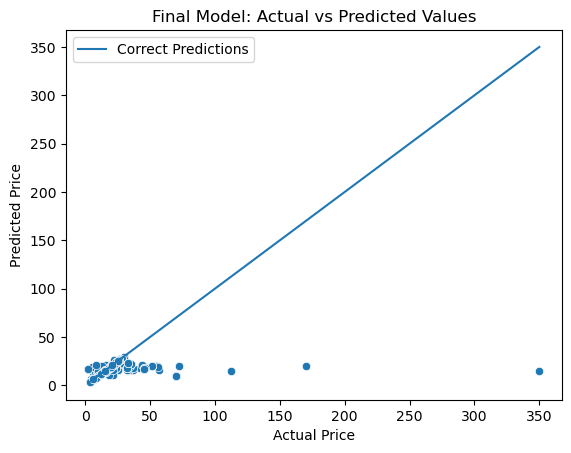

In [51]:
# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, label='Correct Predictions')

ax.set(title='Final Model: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price');

There is an ENORMOUS outlier in the test set. I am going to inspect and remove it, then recalculate the RMSE and R^2 on the test set because the model had no chance of predicting such a high price for a candle-related product.

In [63]:
df.loc[X_test.iloc[np.argmax(y_test)].name, ['product_name', 'product_description']]

product_name                                         Custom Order for KB
product_description    Pine Cones\n\nNatural Yellow -13\n\nMoss - 13\...
Name: 112950, dtype: object

The offending outlier is a custom order with a large number of candles and other decorative items. Drop the outlier and re-compute RMSE and R^2.

In [67]:
X_test_preprocessed.drop(index=X_test.iloc[np.argmax(y_test)].name, inplace=True)
y_test.drop(index=X_test.iloc[np.argmax(y_test)].name, inplace=True)

y_pred = best_rf_model.predict(X_test_preprocessed)
r_2 = best_rf_model.score(X_test_preprocessed, y_test)
print(f'RMSE on hold-out test set: ${round(rmse(y_test, y_pred), 2)}')
print(f'Coefficient of determination (R^2) on hold-out test set: {round(100*r_2, 2)}%')

RMSE on hold-out test set: $11.79
Coefficient of determination (R^2) on hold-out test set: 9.15%


The root mean squared error is still quite a bit higher than I had hoped. If we drop all records with a price higher than the "maximum acceptable price", what is the performance like?

In [73]:
X_test_preprocessed_outliers_removed = X_test_preprocessed.loc[y_test < max_acceptable_price].copy()
y_test_outliers_removed = y_test.loc[y_test < max_acceptable_price].copy()

print(f'Number of candles: {X_test_preprocessed_outliers_removed.shape[0]}')
print(f'Percentage of test data: {round(100*X_test_preprocessed_outliers_removed.shape[0]/X_test.shape[0], 2)}%')
print('\n')

y_pred = best_rf_model.predict(X_test_preprocessed_outliers_removed)
r_2 = best_rf_model.score(X_test_preprocessed_outliers_removed, y_test_outliers_removed)
print(f'RMSE on hold-out test set: ${round(rmse(y_test_outliers_removed, y_pred), 2)}')
print(f'Coefficient of determination (R^2) on hold-out test set: {round(100*r_2, 2)}%')

Number of candles: 902
Percentage of test data: 87.83%


RMSE on hold-out test set: $1.56
Coefficient of determination (R^2) on hold-out test set: 91.19%


In the hold out test data set, slightly more than 87% of candles fall into the "acceptable price range" (are not classified as outliers) according to the interquartile range of the training data.

The best model is, on average, about \\$1.56 away from the true price with its predictions for these "non-outlier" candles, and the model explains nearly 92\% of the variance in the price of these candles.

On the data set as a whole, with the single largest outlier removed, the model is, on average, about \\$11.79 away from the true price with its predictions, and the model only explains about 9\% of the variance in the price of candles.

The conclusion we can draw is, this model can provide some insight on pricing a "typical" candle on Etsy which costs between \\$15 and \\$30. However, the price for sets of candles or customized candles, which can be sold for much more, are not well-approximated by this model.

## Feature Importance (Final Model)

Explore the features which are most important to the model's decision making process regarding price.

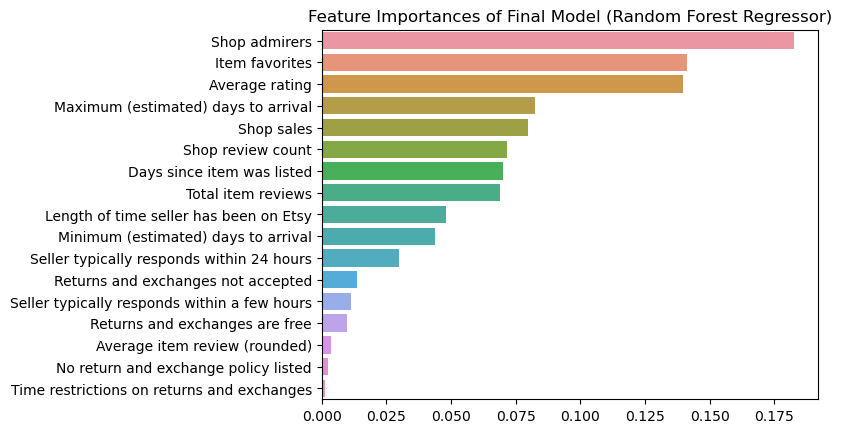

In [95]:
# built-in random forest feature importance

fig, ax = plt.subplots()

sorted_values = sorted(dict(zip(best_rf_model.feature_names_in_, best_rf_model.feature_importances_)).items(),
                       key = lambda x: x[1], reverse=True)

sns.barplot(x=[item[1] for item in sorted_values], y=[item[0] for item in sorted_values])
ax.set_title('Feature Importances of Final Model (Random Forest Regressor)')
ax.set_yticklabels(['Shop admirers', 'Item favorites', 'Average rating', 'Maximum (estimated) days to arrival',
                    'Shop sales', 'Shop review count', 'Days since item was listed', 'Total item reviews',
                    'Length of time seller has been on Etsy', 'Minimum (estimated) days to arrival',
                    'Seller typically responds within 24 hours', 'Returns and exchanges not accepted',
                    'Seller typically responds within a few hours', 'Returns and exchanges are free',
                    'Average item review (rounded)', 'No return and exchange policy listed',
                    'Time restrictions on returns and exchanges']);

Let's also compute the permutation importance (which can often yield a better understanding of the contribution each feature makes to the accuracy of predictions.)

In [86]:
pi = permutation_importance(best_rf_model, X_test_preprocessed_outliers_removed, y_test_outliers_removed,
                            scoring='neg_root_mean_squared_error', n_repeats=3, random_state=seed)

The permutation importance, using the negative RMSE as the score, is the decrease in model performance when a single feature value is randomly shuffled. So we can interpret the importances below as "how much farther off would the model's predictions be without this feature?"

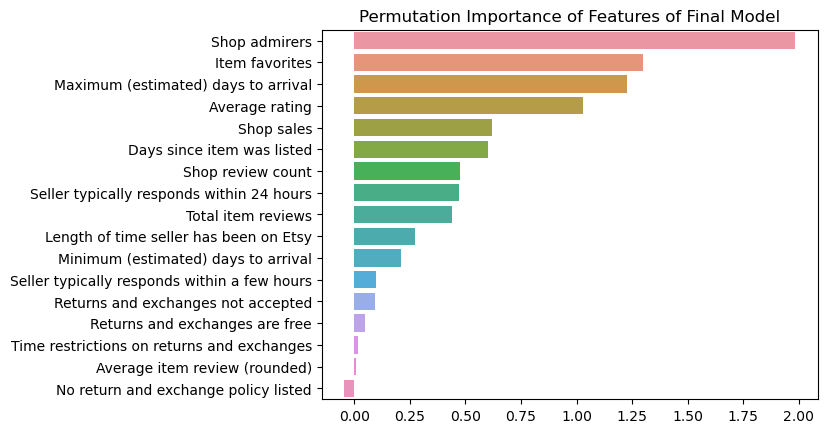

In [94]:
fig, ax = plt.subplots()

sorted_values = sorted(dict(zip(best_rf_model.feature_names_in_, pi['importances_mean'])).items(),
                       key = lambda x: x[1], reverse=True)

sns.barplot(x=[item[1] for item in sorted_values], y=[item[0] for item in sorted_values])
ax.set_title('Permutation Importance of Features of Final Model')
ax.set_yticklabels(['Shop admirers', 'Item favorites', 'Maximum (estimated) days to arrival', 'Average rating',
                    'Shop sales', 'Days since item was listed', 'Shop review count',
                    'Seller typically responds within 24 hours', 'Total item reviews',
                    'Length of time seller has been on Etsy', 'Minimum (estimated) days to arrival',
                    'Seller typically responds within a few hours', 'Returns and exchanges not accepted',
                    'Returns and exchanges are free', 'Time restrictions on returns and exchanges',
                    'Average item review (rounded)', 'No return and exchange policy listed']);

The features which affect model RMSE by a \\$1.00 or more are:

- Shop admirers
- Number of item favorites
- Maximum (estimated) days to arrival
- Average rating

Only one of these features is strictly within the seller's control, but it is worth researching what actions can help a shop to build up its following of admirers and average ratings.

Notably, the return and exchange policy that is listed for an item seems to have little predictive power, so there is little to no incentive to select a policy to try to command a higher price for your candle.

With all of the below visualizations, keep in mind that our model does not predict candles worth more than \\$30 very well - so we are looking for positive and negative correlations with prices of candles between \\$4 and \\$33.

In [103]:
focused_df = df.loc[(df.price>min_acceptable_price)&(df.price<max_acceptable_price)]

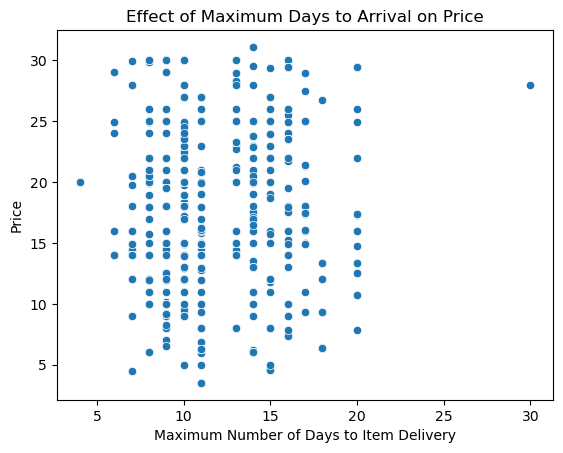

In [104]:
# what is the relationship between max days to arrival and price?

fig, ax = plt.subplots()

sns.scatterplot(x=focused_df.later_days_to_arrival, y=focused_df.price)
ax.set(title='Effect of Maximum Days to Arrival on Price', xlabel='Maximum Number of Days to Item Delivery',
       ylabel='Price');

Practically all candles are promised to be delivered within 20 days, and about half are delivered within 12 or 14 days. However, promising an earlier latest date of arrival does not seem to raise or lower the price that you can charge for the candle.

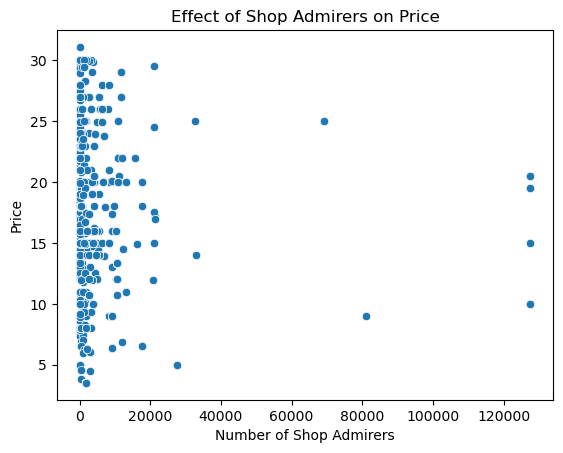

In [105]:
# what is the relationship between shop admirers, item favorites, average rating and price?

fig, ax = plt.subplots()

sns.scatterplot(x=focused_df.num_admirers, y=focused_df.price)
ax.set(title='Effect of Shop Admirers on Price', xlabel='Number of Shop Admirers',
       ylabel='Price');

For the price range which our model does well at predicting, there is no noticeable correlation between the number of shop admirers and price.

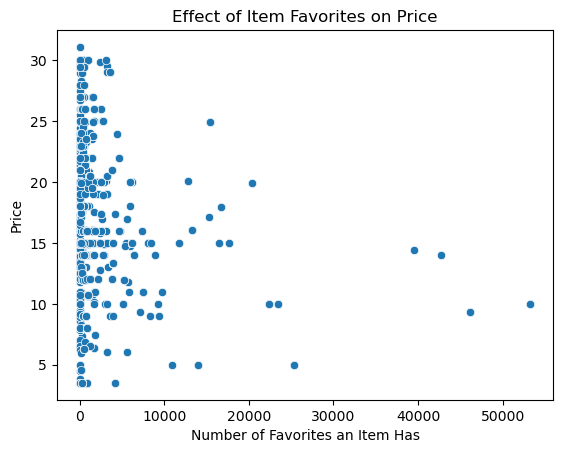

In [106]:
# what is the relationship between shop admirers, item favorites, average rating and price?

fig, ax = plt.subplots()

sns.scatterplot(x=focused_df.item_favorites, y=focused_df.price)
ax.set(title='Effect of Item Favorites on Price', xlabel='Number of Favorites an Item Has',
       ylabel='Price');

A possible slight negative correlation (people may tend to favorite lower-priced items.)

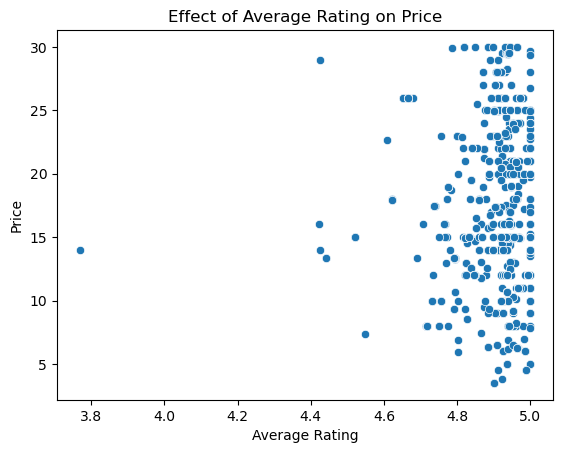

In [107]:
# what is the relationship between shop admirers, item favorites, average rating and price?

fig, ax = plt.subplots()

sns.scatterplot(x=focused_df.avg_rating, y=focused_df.price)
ax.set(title='Effect of Average Rating on Price', xlabel='Average Rating',
       ylabel='Price');

Most candles have an average rating greater than 4.8. There is no clear correlation between average rating and price.

## Conclusion

For a seller or potential seller of candles on Etsy, this pricing model would be appropriate to determine a starting price for a single, non-customizable candle to within \\$1.56 of the actual selling price that similar candles command on Etsy. The model can certainly narrow down a starting price more specifically than using the mean price of a candle on Etsy.

Items such as average rating which are not yet determined for new sellers could be approximated by the mean since practically all candles receive an average rating within a very tight band (4.8 - 5.0 stars), although a more customized rating could be obtained by polling friends and family.

### Recommendations

- If you can profitably make and sell candles for \\$15 to \\$20 each, then selling individual candles on Etsy could be a profitable business.

- Consider selling customized candles or sets to ask for a higher selling price per listing - but note that there is some potential evidence that more affordable candles are more popular on Etsy, so if you can scale well, you may want to focus on less expensive candles.